In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('/content/drive/MyDrive/PFE/ids-ml/notebooks/data/netflow/mixed.csv', index_col='DATE')
df.drop(['FLAGS', 'CLASS', 'ATTACK_ID', 'ATTACK_DESCRIPTION'], axis=1, inplace=True)

df = df.sample(frac=1).iloc[:1000]

df['SRC'] = df['SRC_IP_ADDR'].str.cat(df['SRC_PORT'].astype(str), sep=':')
df['DST'] = df['DST_IP_ADDR'].str.cat(df['DST_PORT'].astype(str), sep=':')
df.drop(['SRC_IP_ADDR', 'SRC_PORT', 'DST_IP_ADDR', 'DST_PORT'], axis=1, inplace=True)
df.head()

,DURATION,PROTOCOL,PACKETS,BYTES,TOS,ATTACK_TYPE,TYPE,SRC,DST
DATE,,,,,,,,,
2017-03-28 15:55:21.416,0.000,TCP,1,54.0,0,benign,internal,192.168.220.15:53201,11396_48:443
2017-03-23 11:38:42.200,0.002,TCP,5,479.0,0,dos,internal,192.168.220.15:44896,192.168.100.6:80
2017-03-24 10:07:21.296,0.000,TCP,1,66.0,32,benign,internal,11653_36:443,192.168.220.4:36909
2017-03-23 13:03:49.133,0.002,UDP,2,652.0,0,benign,internal,DNS:53,192.168.220.16:48458
2017-03-24 15:07:48.019,0.019,TCP,2,108.0,0,benign,internal,10163_60:80,192.168.200.8:53667


In [6]:
from sklearn.preprocessing import LabelEncoder

def label_encode(series_to_encode):
    lb_e = LabelEncoder()
    return lb_e, lb_e.fit_transform(series_to_encode)

FEATURES_TO_LABELENCODE = ['PROTOCOL', 'TYPE', 'TOS', 'ATTACK_TYPE', 'SRC', 'DST']
encoders = {}

for f in FEATURES_TO_LABELENCODE:
    print("Processing feature {}".format(f))
    encoders[f], df[f] = label_encode(df[f])

Processing feature PROTOCOL
Processing feature TYPE
Processing feature TOS
Processing feature ATTACK_TYPE
Processing feature SRC
Processing feature DST


In [7]:
nodes_df = pd.concat([
    df[['SRC', 'TYPE']].rename(columns={'SRC': 'ID'}).reset_index(drop=True), 
    df[['DST', 'TYPE']].rename(columns={'DST': 'ID'}).reset_index(drop=True)
]).drop_duplicates()

nodes_df['COLOR'] = np.where(nodes_df['TYPE'] == 0, "#107be6", "#000000")
nodes_df.drop('TYPE', axis=1, inplace=True)

nodes_df.head()

,ID,COLOR
0,543,#000000
1,497,#000000
2,239,#000000
3,714,#000000
4,101,#000000


In [8]:
edges_df = df[['SRC', 'DST', 'DURATION', 'PROTOCOL', 'PACKETS', 'BYTES', 'TOS', 'ATTACK_TYPE']]
edges_df['SPEED'] = edges_df['BYTES'] / edges_df['DURATION']
edges_df['SPEED'] = edges_df['SPEED'].replace([np.inf, -np.inf], 0.01)

edges_df.reset_index(inplace=True, drop=True)

edges_df.head()

,SRC,DST,DURATION,PROTOCOL,PACKETS,BYTES,TOS,ATTACK_TYPE,SPEED
0,543,194,0.000,1,1,54.0,0,0,0.010000
1,497,246,0.002,1,5,479.0,0,2,239500.000000
2,239,623,0.000,1,1,66.0,1,0,0.010000
3,714,608,0.002,2,2,652.0,0,0,326000.000000
4,101,265,0.019,1,2,108.0,0,0,5684.210526


In [ ]:
! pip install node2vec

In [12]:
import sys
sys.path.append('/content/drive/MyDrive/PFE/ids-ml')

from graphs.multigraph import Multigraph
from embeddings.b_node2vec import Node2VecBaseline
from dim_reducers.b_tsne import tSNEBaseline

In [13]:
multigraph = Multigraph()

multigraph.add_nodes(nodes_df)
multigraph.add_edges(edges_df)

multigraph.plot()

# Essaie **1**
changement des parametres node2vec
1000 - 80 - 100

In [ ]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 1000, 80)
embeddings.fit()
embeddings.node_embeddings
tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

In [ ]:
tsne.plot(colors)

# Essaie **2**
changement des parametres node2vec
1000 - 50 - 50

In [32]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 1000, 50,50)
embeddings.fit()
embeddings.node_embeddings
tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

Generating walks (CPU: 1):   0%|          | 0/50 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


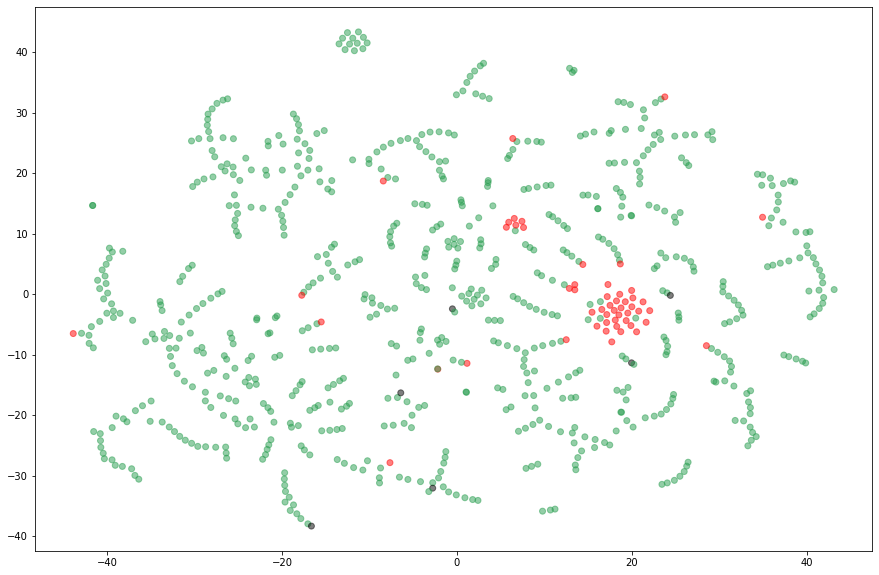

In [39]:
tsne.plot(colors)

# Essaie *3*
changement des parametres node2vec
4 - 80 - 100 

In [ ]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 4, 80,100)


In [58]:
embeddings.fit()
embeddings.node_embeddings
tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.319702
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.733597
[t-SNE] KL divergence after 1000 iterations: 0.662011


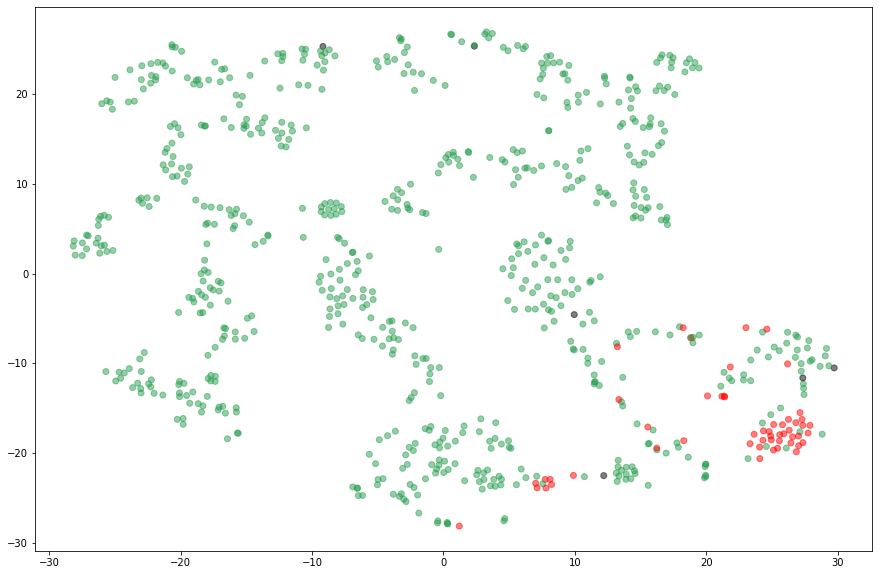

In [59]:
tsne.plot(colors)

# Essaie *4*
changement des parametres node2vec
4 - 50 - 50 

In [50]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, 4,50,100)
embeddings.fit()
embeddings.node_embeddings
tsne = tSNEBaseline(n_components=2, perplexity=30, n_iter=1000, verbose=1)
tsne.fit(embeddings.node_embeddings)
dst_nodes_edges_colors = {e[0]: e[2].get('color') for e in multigraph._G.edges.data()}
colors = [dst_nodes_edges_colors.get(int(x), "#299e50") for x in embeddings.node_embeddings_id]

Generating walks (CPU: 1):   0%|          | 0/100 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.313407
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.002121
[t-SNE] KL divergence after 1000 iterations: 0.634295


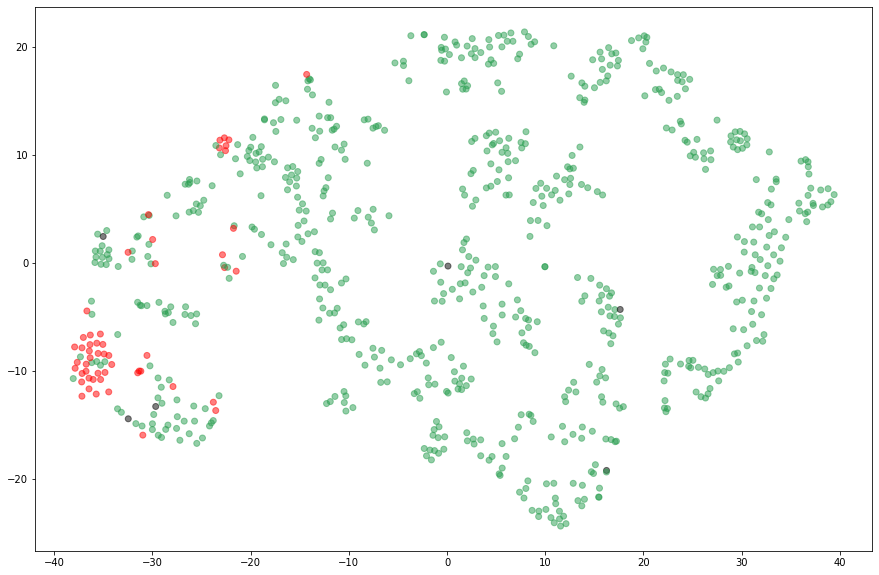

In [51]:
tsne.plot(colors)

# Test *tsne*
changement des parametres TSNE


In [ ]:
embeddings = Node2VecBaseline.from_networkx_graph(multigraph._G, dimensions=4, walk_length=80, num_walks=100)

[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 0.000000
[t-SNE] KL divergence after 650 iterations: 0.000000
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.104649
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.679047
[t-SNE] KL divergence after 1000 iterations: 0.569090
[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.161890
[t-SNE] KL divergence after 250 iterations 

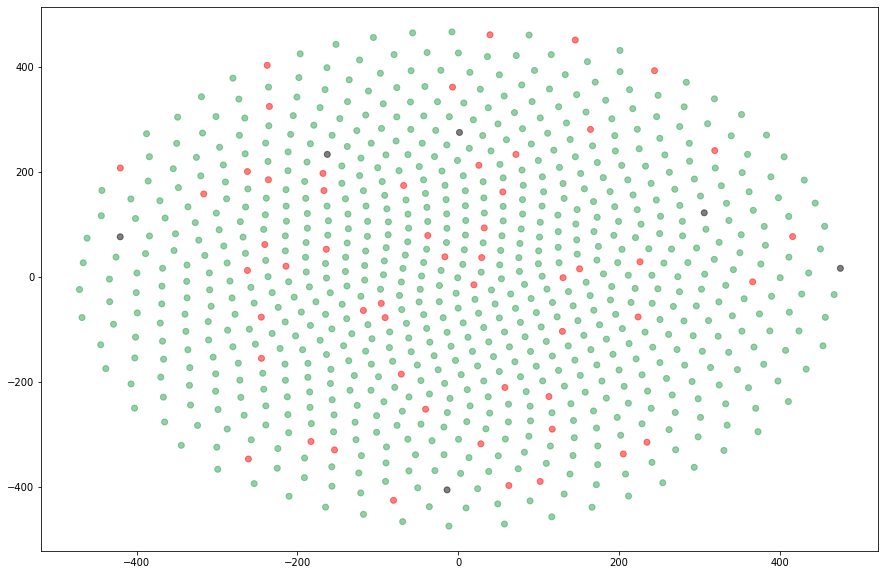

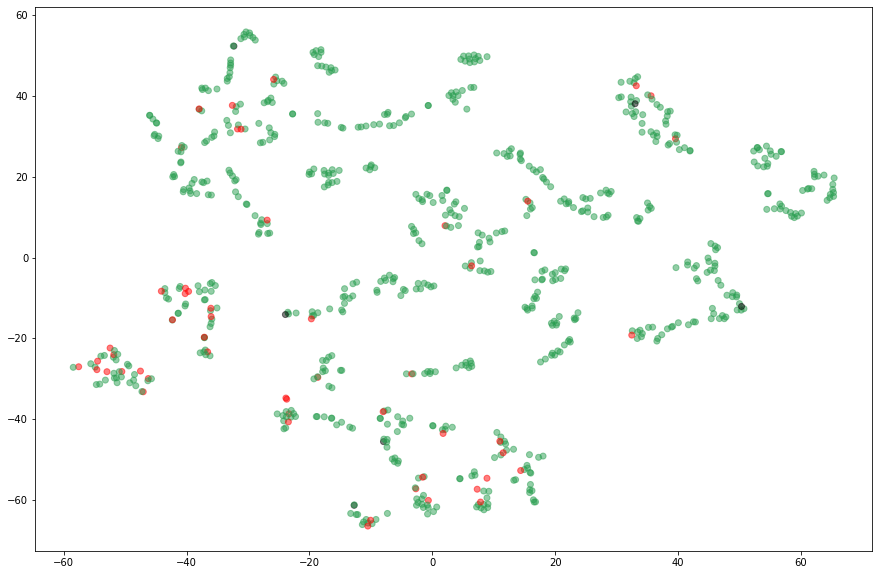

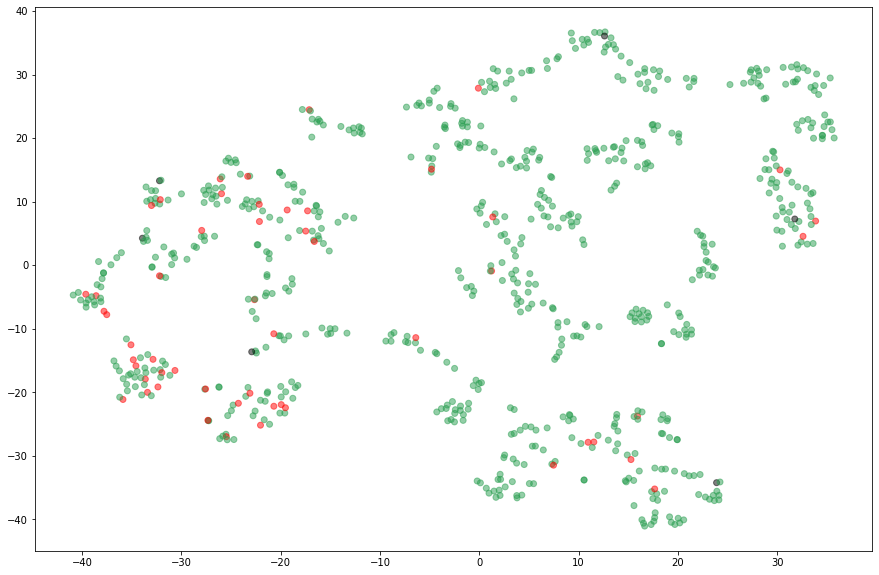

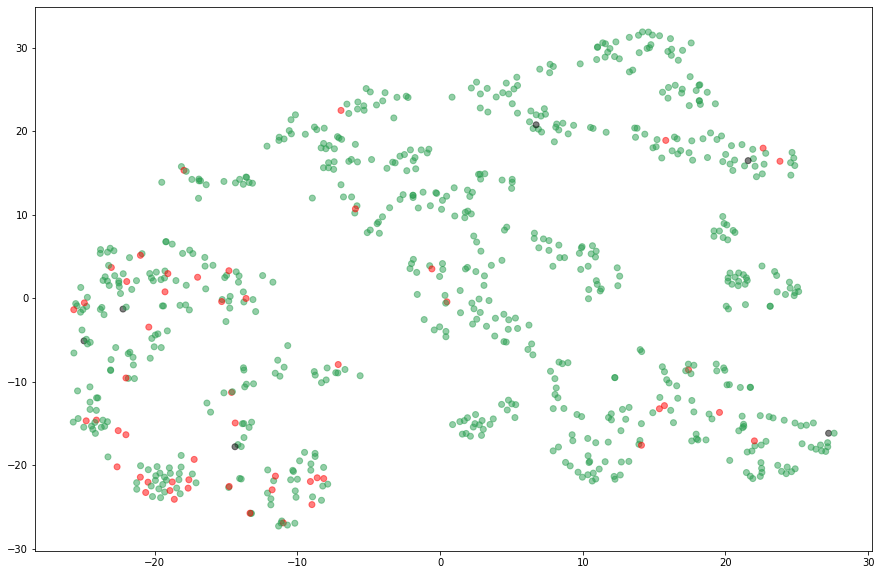

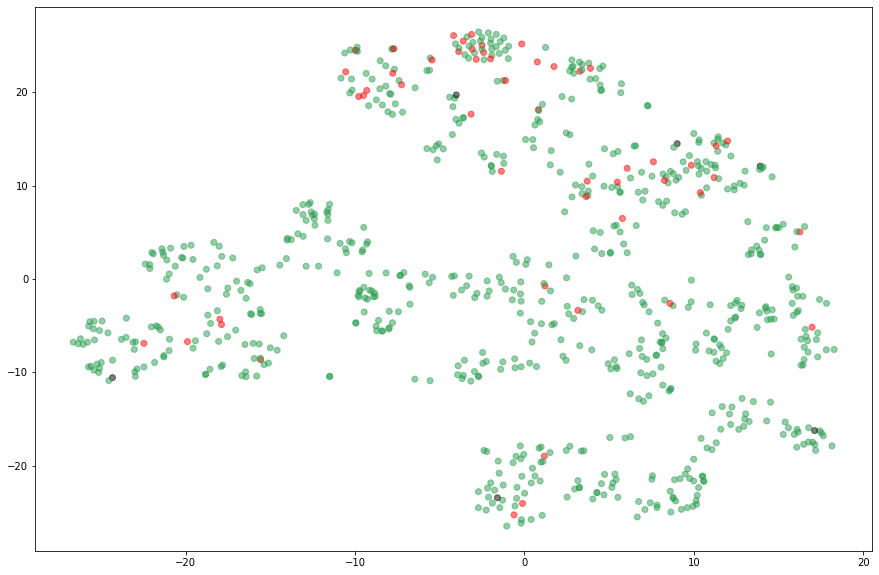

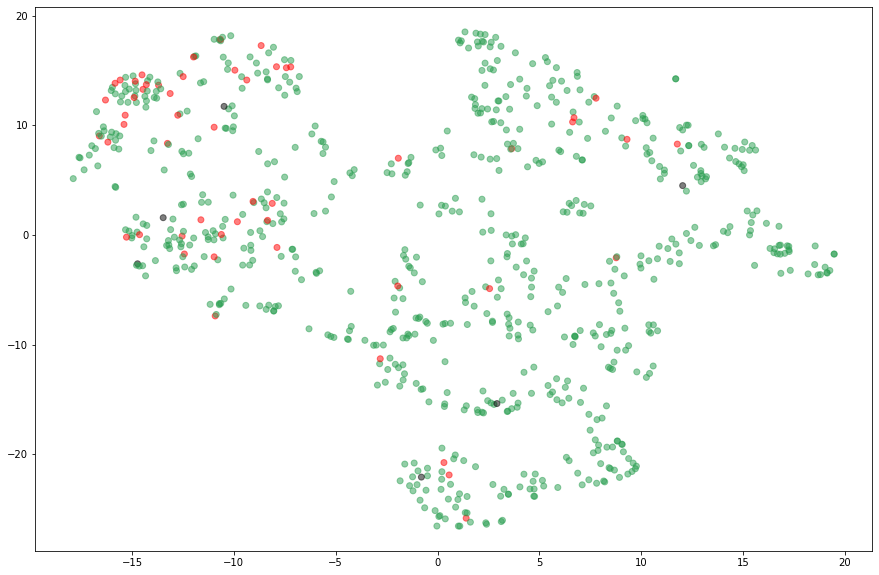

In [61]:
embeddings.fit()
for i in range(0, 51, 10):
  tsne = tSNEBaseline(n_components=2, perplexity=i, n_iter=1000, verbose=1)
  tsne.fit(embeddings.node_embeddings)
  tsne.plot(colors)

# **Evaluation Score**

In [84]:
X = embeddings.node_embeddings_id
y = colors

In [85]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, test_size=None)

In [86]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(
    Cs=10, cv=10, scoring="accuracy", verbose=False, multi_class="ovr", max_iter=300)
clf.fit(X_train, y_train)

ValueError: ignored

In [ ]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)